In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import warnings
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tqdm.notebook import tqdm # Tạo progressbar trên jupyter
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
(X_train, y_train),(X_test, y_test) = mnist.load_data()
print('X_train shape:{}'.format(X_train.shape))
print('y_train shape:{}'.format(y_train.shape))
print('X_test shape:{}'.format(X_test.shape))
print('y_test shape:{}'.format(y_test.shape))

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
X_train shape:(60000, 28, 28)
y_train shape:(60000,)
X_test shape:(10000, 28, 28)
y_test shape:(10000,)


In [3]:
X_train = X_train.reshape(60000,784) #flatten 784
X_test = X_test.reshape(10000,784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

In [4]:
#Vector nosie
z_dim = 100

Xây dựng mô hình Generator

In [5]:
adam = Adam(learning_rate=0.0002, beta_1=0.5)
g_model = Sequential()
g_model.add(Dense(256, input_dim=z_dim, activation=LeakyReLU(0.2)))
g_model.add(Dense(512, activation=LeakyReLU(0.2)))
g_model.add(Dense(1024, activation=LeakyReLU(0.2)))
#Output là binary
g_model.add(Dense(784, activation='sigmoid'))

In [6]:
g_model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

In [7]:
g_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        25,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 784)            │       803,600 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,486,352 (5.67 MB)

 Trainable params: 1,486,352 (5.67 MB)

 Non-trainable params: 0 (0.00 B)

Xây dựng mô hình discriminator

In [8]:
d_model = Sequential()
d_model.add(Dense(1024,input_dim=784, activation=LeakyReLU(0.2)))
d_model.add(Dropout(0.3))
d_model.add(Dense(512, activation=LeakyReLU(0.2)))
d_model.add(Dropout(0.3))
d_model.add(Dense(256, activation=LeakyReLU(0.2)))
d_model.add(Dropout(0.3))
d_model.add(Dense(1, activation='sigmoid'))

In [9]:
d_model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

In [10]:
d_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 1024)           │       803,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,460,225 (5.57 MB)

 Trainable params: 1,460,225 (5.57 MB)

 Non-trainable params: 0 (0.00 B)

Tạo GAN kết nối Generator và Discriminator

In [11]:
d_model.trainable = False # Mô hình nhận diện không huấn luyện
inputs = Input(shape=(z_dim,))
hidden = g_model(inputs)
output = d_model(hidden)
gan = tf.keras.Model(inputs, output)
gan.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002,beta_1=0.5),metrics=['accuracy'])

In [12]:
# Hàm vẽ loss function
def plot_loss(losses):
    d_loss = [v[0] for v in losses["D"]]
    g_loss = [v[0] for v in losses["G"]]

    plt.figure(figsize=(10,8))
    plt.plot(d_loss, label="Discriminator loss")
    plt.plot(g_loss, label="Generator loss")

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
# Hàm vẽ generated
def plot_generated(n_ex=10, dim=(1, 10), figsize=(12, 2)):
    noise = np.random.normal(0, 1, size=(n_ex, z_dim))
    generated_images = g_model.predict(noise)
    generated_images = generated_images.reshape(n_ex, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [13]:
losses = {"D": [], "G": []}

def train(epochs=1, plt_frq=1, BATCH_SIZE=128):
    batchCount = int(X_train.shape[0] / BATCH_SIZE)
    print('Epochs:', epochs)
    print('Batch size:', BATCH_SIZE)
    print('Batches per epoch:', batchCount)

    for e in tqdm(range(1, epochs + 1)):
        if e == 1 or e % plt_frq == 0:
            print('-' * 15, f'Epoch {e}', '-' * 15)

        for _ in range(batchCount):
            # ----- Train Discriminator -----
            # Ảnh thật
            real_imgs = X_train[np.random.randint(0, X_train.shape[0], BATCH_SIZE)]
            # Noise
            noise = np.random.normal(0, 1, (BATCH_SIZE, z_dim))
            # Ảnh sinh
            generated_imgs = g_model.predict(noise,verbose=0)

            # Gộp ảnh
            X = np.concatenate([real_imgs, generated_imgs])
            y = np.zeros(2 * BATCH_SIZE)
            y[:BATCH_SIZE] = 0.9  # Label smoothing: real=0.9, fake=0

            d_model.trainable = True
            d_loss = d_model.train_on_batch(X, y)

            # ----- Train Generator -----
            noise = np.random.normal(0, 1, (BATCH_SIZE, z_dim))
            y_gen = np.ones(BATCH_SIZE)  # muốn D nghĩ ảnh giả là thật
            d_model.trainable = False
            g_loss = gan.train_on_batch(noise, y_gen)

        # Ghi log
        losses["D"].append(d_loss)
        losses["G"].append(g_loss)

        # Vẽ ảnh mỗi plt_frq epoch
        if e == 1 or e % plt_frq == 0:
            plot_generated()

    plot_loss(losses)

Epochs: 200
Batch size: 128
Batches per epoch: 468


  0%|          | 0/200 [00:00<?, ?it/s]

--------------- Epoch 1 ---------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


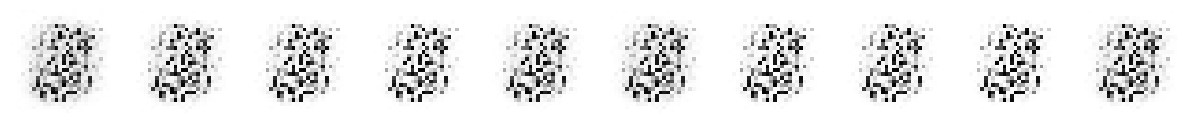

--------------- Epoch 20 ---------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


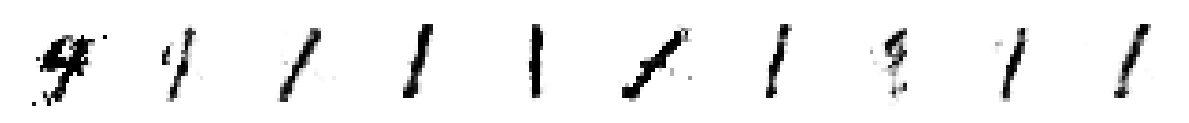

--------------- Epoch 40 ---------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


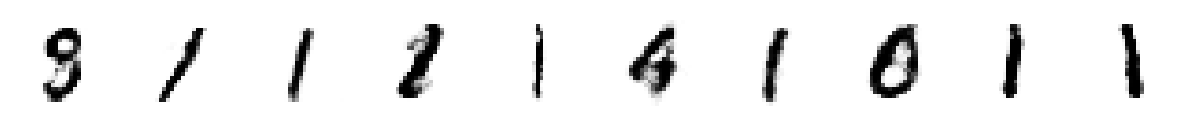

--------------- Epoch 60 ---------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


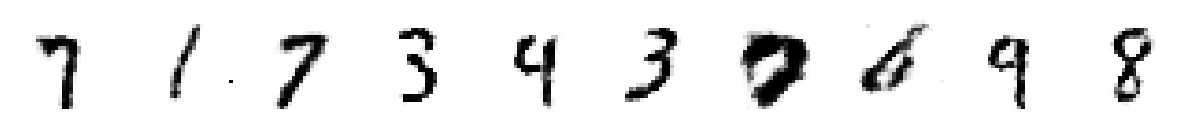

--------------- Epoch 80 ---------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


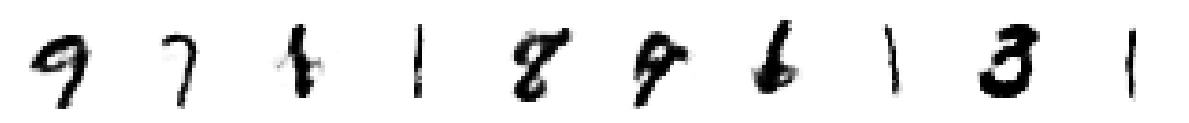

--------------- Epoch 100 ---------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


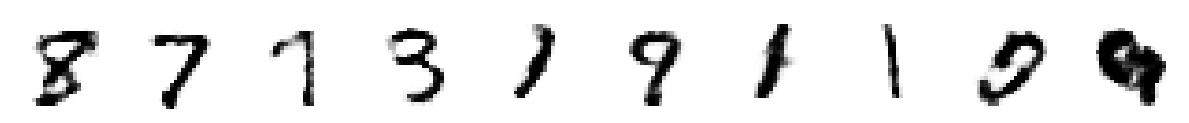

KeyboardInterrupt: 

In [14]:
train(epochs=200, plt_frq=20, BATCH_SIZE=128)